# Toyota Yaris II -  price prediction (draft)


Notebook do analizy cen samochodu Yaris II

Podstawowe informacje:
 - rok produkcji: 2005–2011
 - silniki Benzyna, Diesel, Benzyna + LPG
 - Skrzynia biegów: 5MT, 6MT

| Model              | Pojemność | Cylindry | Moc                             | Moment obrotowy             | Skrzynia biegów    | Rok             |
|--------------------|-----------|----------|---------------------------------|-----------------------------|--------------------|-----------------|
| 1.0 VVT-i          | 998 cm³   | 3        | 51 kW (69 PS) przy 6000 min−1   | 93 Nm przy 3600 min−1       | 5MT                | 2005–2011       |
| 1.3 VVT-i          | 1298 cm³  | 4        | 64 kW (87 PS) przy 6000 min−1   | 121 Nm przy 4200 min−1      | 5MT / 5AT          | 2005–2008       |
| 1.33 Dual VVT-i    | 1329 cm³  | 4        | 73 kW (99 PS) przy 6000 min−1   | 128 Nm przy 3800 min−1      | 6MT / 6AT          | 09/2010–2011    |
|                    |           | 4        | 74 kW (101 PS) przy 6000 min−1  | 132 Nm przy 3800 min−1      | 6MT / 6AT          | 2009–09/2010    |
| 1.8 TS VVT-i       | 1798 cm³  | 4        | 98 kW (133 PS) przy 6000 min−1  | 173 Nm przy 4400 min−1      | 5MT / 6AT (Import) | 01/2007–01/2009 |
| 1.8 TS Bemani (CH) | 1798 cm³  | 4        | 158 kW (215 PS) przy 6000 min−1 | 270 Nm przy 4800 min−1      | 6MT                | 03/2009–2010    |
| 1.4 D-4D           | 1364 cm³  | 4        | 66 kW (90 PS) przy 3800 min−1   | 190 Nm przy 1800–3000 min−1 | 5MT / 5AT          | 2006–2009       |

Wg portalu Autocentrum w tym modelu były dostępne następujące wersje silnikowe:

Benzyna:
- 1.0  VVT-i      69KM 51kW (2005-2011) - 998 cm3, 5MT

- 1.3i VVT-i      86KM 63kW (2005-2010) - 1296 cm3, 5MT

- 1.33 Dual VVT-i 101KM 74kW (2009-2011) - 1329 cm3, 6MT

- 1.8i VVT-i      133KM 98kW (2005-2010) - 1798 cm3, 6MT

Diesel:
- 1.4 D-4D 90KM 66kW (2005-2011) - 1364 cm3, 5MT

## Wczytanie i przegląd danych

In [343]:
import pandas as pd
import numpy as np
import sqlite3

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def get_view_data():
    sql_query = """SELECT * FROM v_cars"""
    conn = sqlite3.connect("./py_otomoto/pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

def get_view2_data():
    sql_query = """SELECT * FROM v_cars2"""
    conn = sqlite3.connect("./py_otomoto/pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

def get_data():
    sql_query ="""
SELECT 
    all_offers.offer_id,otomoto_all.s_date, otomoto_all.e_date, all_offers.private_business, all_offers.region,
    all_offers.city, all_offers.model, all_offers.year, all_offers.mileage, all_offers.engine_capacity, all_offers.vin,
    all_offers.fuel_type, all_offers.engine_power, all_offers.gearbox, all_offers.transmission, all_offers.door_count,
    all_offers.nr_seats, all_offers.color, all_offers.features,otomoto_all.price, all_offers.price_raw, all_offers.currency, 
    all_offers.country_origin, all_offers.registration
FROM 
    otomoto_all, all_offers
WHERE 
    otomoto_all.uid = all_offers.uid; 
"""

    conn = sqlite3.connect("./py_otomoto/pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

# %time df = get_data() #~13 ms
%time df = get_view2_data() #~13 ms

#%time for i in range(3000): df = get_data()

df.head(3)

Wall time: 21 ms


,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,vin,fuel_type,engine_power,gearbox,transmission,door_count,nr_seats,color,features,price,price_raw,date,currency,country_origin,registration
0,6005738641,2020-04-17,2020-06-08,business,malopolskie,krakow,yaris,2009,111000,1000,0,petrol,0,manual,front-wheel,5,5,grey,0,6200,6200.0,2020-04-17,0,f,0
1,6018694885,2020-04-17,2020-05-26,business,warminsko-mazurskie,ostroda,yaris,2008,45706,998,0,petrol,0,manual,0,3,5,white,abs central-lock electronic-immobiliser front-...,4700,4700.0,2020-04-17,0,pl,0
2,6025678407,2020-04-17,2020-06-02,business,mazowieckie,milanowek,yaris,2009,174000,1300,0,petrol,100,manual,0,5,5,silver,abs cd central-lock front-electric-windows ele...,19800,19800.0,2020-04-17,0,0,0


In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   offer_id          463 non-null    int64  
 1   s_date            463 non-null    object 
 2   e_date            463 non-null    object 
 3   private_business  463 non-null    object 
 4   region            463 non-null    object 
 5   city              463 non-null    object 
 6   model             463 non-null    object 
 7   year              463 non-null    int64  
 8   mileage           463 non-null    int64  
 9   engine_capacity   463 non-null    int64  
 10  vin               463 non-null    object 
 11  fuel_type         463 non-null    object 
 12  engine_power      463 non-null    int64  
 13  gearbox           463 non-null    object 
 14  transmission      463 non-null    object 
 15  door_count        463 non-null    int64  
 16  nr_seats          463 non-null    int64  
 1

In [345]:
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

In [346]:
feat_en_pl = {
    "abs" : "ABS",
    "cd" : "CD",
    "central-lock" : "Centralny zamek",
    "front-electric-windows" : "Elektryczne szyby przednie",
    "electronic-rearview-mirrors" : "Elektrycznie ustawiane lusterka",
    "electronic-immobiliser" : "Immobilizer",
    "front-airbags" : "Poduszka powietrzna kierowcy",
    "front-passenger-airbags" : "Poduszka powietrzna pasażera",
    "original-radio" : "Radio fabryczne",
    "assisted-steering" : "Wspomaganie kierownicy",
    "alarm" : "Alarm",
    "alloy-wheels" : "Alufelgi",
    "asr" : "ASR (kontrola trakcji)",
    "park-assist" : "Asystent parkowania",
    "lane-assist" : "Asystent pasa ruchu",
    "bluetooth" : "Bluetooth",
    "automatic-wipers" : "Czujnik deszczu",
    "blind-spot-sensor" : "Czujnik martwego pola",
    "automatic-lights" : "Czujnik zmierzchu",
    "both-parking-sensors" : "Czujniki parkowania przednie",
    "rear-parking-sensors" : "Czujniki parkowania tylne",
    "panoramic-sunroof" : "Dach panoramiczny",
    "electric-exterior-mirror" : "Elektrochromatyczne lusterka boczne",
    "electric-interior-mirror" : "Elektrochromatyczne lusterko wsteczne",
    "rear-electric-windows" : "Elektryczne szyby tylne",
    "electric-adjustable-seats" : "Elektrycznie ustawiane fotele",
    "esp" : "ESP (stabilizacja toru jazdy)",
    "aux-in" : "Gniazdo AUX",
    "sd-socket" : "Gniazdo SD",
    "usb-socket" : "Gniazdo USB",
    "towing-hook" : "Hak",
    "head-display" : "HUD (wyświetlacz przezierny)",
    "isofix" : "Isofix",
    "rearview-camera" : "Kamera cofania",
    "automatic-air-conditioning" : "Klimatyzacja automatyczna",
    "quad-air-conditioning" : "Klimatyzacja czterostrefowa",
    "dual-air-conditioning" : "Klimatyzacja dwustrefowa",
    "air-conditioning" : "Klimatyzacja manualna",
    "onboard-computer" : "Komputer pokładowy",
    "side-window-airbags" : "Kurtyny powietrzne",
    "shift-paddles" : "Łopatki zmiany biegów",
    "mp3" : "MP3",
    "gps" : "Nawigacja GPS",
    "dvd" : "Odtwarzacz DVD",
    "speed-limiter" : "Ogranicznik prędkości",
    "auxiliary-heating" : "Ogrzewanie postojowe",
    "heated-windshield" : "Podgrzewana przednia szyba",
    "heated-rearview-mirrors" : "Podgrzewane lusterka boczne",
    "front-heated-seats" : "Podgrzewane przednie siedzenia",
    "rear-heated-seats" : "Podgrzewane tylne siedzenia",
    "driver-knee-airbag" : "Poduszka powietrzna chroniąca kolana",
    "front-side-airbags" : "Poduszki boczne przednie",
    "rear-passenger-airbags" : "Poduszki boczne tylne",
    "tinted-windows" : "Przyciemniane szyby",
    "radio" : "Radio niefabryczne",
    "adjustable-suspension" : "Regulowane zawieszenie",
    "roof-bars" : "Relingi dachowe", 
    "system-start-stop" : "System Start-Stop",
    "sunroof" : "Szyberdach", 
    "daytime-lights" : "Światła do jazdy dziennej",
    "leds" : "Światła LED",
    "fog-lights" : "Światła przeciwmgielne",
    "xenon-lights" : "Światła Xenonowe",
    "leather-interior" : "Tapicerka skórzana",
    "velour-interior" : "Tapicerka welurowa",
    "cruise-control" : "Tempomat",
    "active-cruise-control" : "Tempomat aktywny",
    "tv" : "Tuner TV",
    "steering-whell-comands" : "Wielofunkcyjna kierownica",
    "cd-changer" : "Zmieniarka CD" }

## Porządkowanie danych

In [347]:
# offer_id - numer oferty
df['offer_id'] = pd.to_numeric(df['offer_id'], downcast='unsigned')

### s_date / e_date

In [348]:
# s_date - data publikacji ogłoszenia 
# e_date - data końca ogłoszenia

print('s_date: ', df['s_date'].dtypes, 'e_date: ', df['e_date'].dtypes)

if  (df['s_date'].dtypes == object) & (df['s_date'].dtypes == object):
    df['s_date'] = pd.to_datetime(df['s_date']) 
    df['e_date'] = pd.to_datetime(df['e_date'])
    df['date'] = pd.to_datetime(df['s_date']) 
    
print('s_date: ', df['s_date'].dtypes, 'e_date: ', df['e_date'].dtypes)

s_date:  object e_date:  object
s_date:  datetime64[ns] e_date:  datetime64[ns]


### private_business

private_business:
 business    234
private     229
Name: private_business, dtype: int64


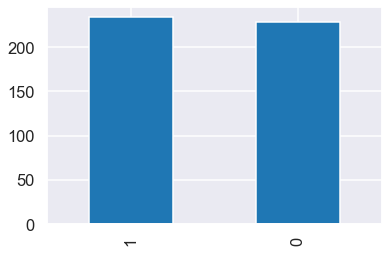

In [349]:
#print('private_business: ', df['private_business'].dtypes)
print('private_business:\n', df['private_business'].value_counts()) # business : 1 / private : 0

if df['private_business'].dtypes == 'object':
    df['private_business'] = df['private_business'].apply(lambda x : str(x) == 'business' )
    df['private_business'] = df['private_business'].astype(np.int8)

df['private_business'].value_counts().plot(kind='bar');

### Region / City / Model

In [350]:
# region 
print('region: ', df['region'].dtypes)
print('region: ', df['region'].unique())

region:  object
region:  ['malopolskie' 'warminsko-mazurskie' 'mazowieckie' 'dolnoslaskie'
 'wielkopolskie' 'slaskie' 'podkarpackie' 'podlaskie' 'lodzkie'
 'zachodniopomorskie' 'lubelskie' 'swietokrzyskie' 'opolskie'
 'kujawsko-pomorskie' 'lubuskie' 'pomorskie']


In [351]:
# chart = sns.countplot(x='region', data=df)
# chart.set_xticklabels(chart.get_xticklabels(), rotation = 90);

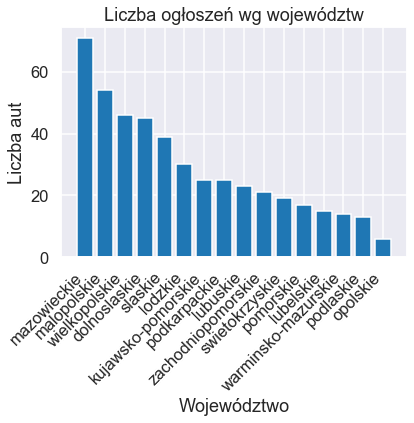

In [352]:
region_cnt = df['region'].value_counts()

fig = plt.figure()
axes = fig.add_axes([0.1 ,0.1 ,0.8, 0.8]) 
axes.bar(region_cnt.index, region_cnt.values)

axes.set_xlabel('Województwo')
axes.set_ylabel('Liczba aut')
axes.set_title('Liczba ogłoszeń wg województw')

for label in axes.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')

In [353]:
# city
print('city: ', df['city'].dtypes, 'Entries:', df['city'].nunique())

city:  object Entries: 168


In [354]:
# model
print('model: ', df['model'].dtypes, df['model'].unique())

model:  object ['yaris']


In [355]:
# year - lata produkcji Yaris II: 2005 - 2011
print('year: ', df['year'].dtypes)
print('year: ', *df['year'].unique())

year:  int64
year:  2009 2008 2006 2005 2007 2010 2011 2002 2014 2016


In [356]:
# mileage
print('mileage: ', df['mileage'].dtypes)
print('mileage: ', df['mileage'].nunique())
print('MIN: ', df['mileage'].min(), 'MAX: ', df['mileage'].max())

mileage:  int64
mileage:  237
MIN:  9100 MAX:  410000


### Engine

engine_capacity:  int64
engine_capacity:  1000 998 1300 1364 1298 1400 1398 1329 0 1798 1323 966 1324 996 988 1332 1296 1330 999 1290 1335 1333 993


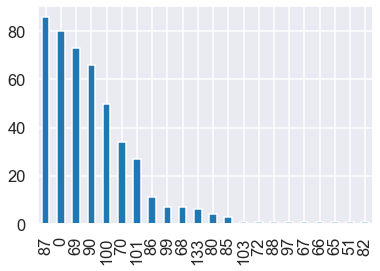

In [357]:
# capacity
print('engine_capacity: ', df['engine_capacity'].dtypes)
print('engine_capacity: ', *df['engine_capacity'].unique())
df['engine_power'].value_counts().plot(kind='bar');

engine_power:  int64
engine_power:  0 100 87 90 86 69 101 70 82 133 68 85 88 80 66 99 72 65 103 97 67 51


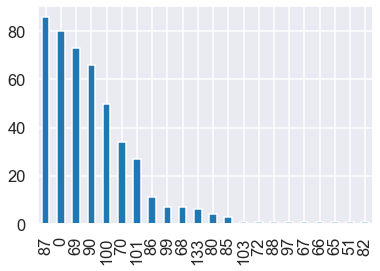

In [358]:
# engine_power - Moc W KM
# 1kW = 1,36 KM
# Powinno być: Benzyna: 69, 86, 101,133 Diesel: 90 

print('engine_power: ', df['engine_power'].dtypes)
print('engine_power: ', *df['engine_power'].unique())
df['engine_power'].value_counts().plot(kind='bar');

In [359]:
engine_details = {
    "R3_10_69KM" : {"power" : 69 , "fuel" : "petrol", "capacity" : 998, "gearbox" : "5MT", "Date" : "2005-2011"},
    "R4_13_86KM" : {"power" : 86 , "fuel" : "petrol", "capacity": 1296, "gearbox" : "5MT", "Date" : "2005-2008"},
    "R4_133_99KM" : {"power" : 101 , "fuel" : "petrol", "capacity": 1329, "gearbox" : "6MT", "Date" : "09/2010 - 2011"},
    "R4_133_101KM" : {"power" : 101 , "fuel" : "petrol", "capacity": 1329, "gearbox" : "6MT", "Date" : "2009 - 09/2010"},
    "R4_18_133KM" : {"power" : 133 , "fuel" : "petrol", "capacity": 1798, "gearbox" : "6MT", "Date": "01/2007 - 01/2009"},
    "R4_18_215KM" : {"power" : 215 , "fuel" : "petrol", "capacity": 1798, "gearbox" : "6MT", "Date" : "03/2009 - 2010"},
    "R4_14_D4D" : {"power" : 90 , "fuel" : "diesel", "capacity": 1364, "gearbox" : "5MT", "Date" : "2006 - 2009"},
}

In [360]:
def get_engine_code(engine_capacity, fuel_type, engine_power, year):
    if (engine_capacity <= 1000) & (fuel_type[0:6] == 'petrol'):
        return 'R3_10_69KM'
    elif ( 1000 <= engine_capacity <= 1350) & (fuel_type[0:6] == 'petrol') & (engine_power < 80):
        return 'R4_13_86KM'
    elif (year <= 2008) & (fuel_type[0:6] == 'petrol') & (engine_power < 95):
        return 'R4_13_86KM'
    elif (year >= 2009) & (fuel_type[0:6] == 'petrol') & (95 <= engine_power < 99):
        return 'R4_133_99KM'
    elif (year >= 2009) & (fuel_type[0:6] == 'petrol') & (99 <= engine_power < 110):
        return 'R4_133_101KM'
    elif (engine_capacity >= 1400) & (fuel_type[0:6] == 'petrol'):
        return 'R4_18_133KM'
    elif fuel_type[0:6] == 'diesel':
        return 'R4_14_D4D'
    elif engine_power > 150:
        return 'R4_18_215KM'
    else:
        return 'NA'
    
df['engine'] = df.apply(lambda x: get_engine_code(x['engine_capacity'], x['fuel_type'], x['engine_power'], x['year']), axis=1)

In [361]:
feats = ["offer_id","engine","engine_capacity", "fuel_type", "engine_power", "gearbox", "year"]
df[feats][df.engine == 'NA']

,offer_id,engine,engine_capacity,fuel_type,engine_power,gearbox,year
3,6027129122,NA,1300,petrol,87,manual,2009
52,6061613472,NA,1300,petrol,90,manual,2010
63,6065067561,NA,1300,petrol,87,manual,2009
68,6065479018,NA,1300,petrol,86,manual,2009
120,6068481479,NA,1324,petrol,100,manual,2008
181,6069517302,NA,1300,petrol,87,manual,2009
182,6069517302,NA,1300,petrol,87,manual,2009
183,6069517302,NA,1300,petrol,87,manual,2009
184,6069528428,NA,1300,petrol,86,manual,2009
296,6071596035,NA,1290,petrol,90,manual,2011


### VIN

In [362]:
# vin
print('vin: ', df['vin'].dtypes, df['vin'].unique())

vin:  object ['0']


W żadnym ogłoszeniu nie był podany numer VIN

fuel_type:  object
fuel_type:  ['petrol' 'diesel' 'petrol-lpg']


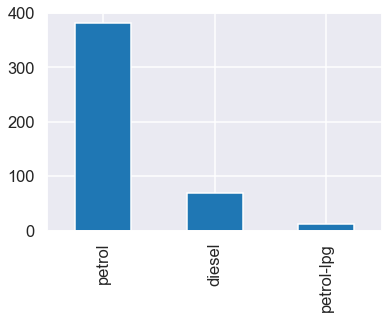

In [363]:
# fuel_type
print('fuel_type: ', df['fuel_type'].dtypes)
print('fuel_type: ', df['fuel_type'].unique())

df['fuel_type'].value_counts().plot(kind='bar');

In [364]:
# gearbox

print('gearbox: ', df['gearbox'].dtypes)
print('gearbox: ', df['gearbox'].unique())
df[(df.gearbox == 'semi-automatic') | (df.gearbox == 'automatic') | (df.gearbox == 'automatic-sequential')]  # 4 samochody z automatyczną skrzynią


gearbox:  object
gearbox:  ['manual' 'semi-automatic' '0' 'automatic' 'automatic-sequential']


,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,vin,fuel_type,...,transmission,door_count,nr_seats,color,features,price,price_raw,date,currency,country_origin,registration,engine
47,6060165978,2020-04-17,2020-06-06,1,podkarpackie,ropczyce,yaris,2008,195000,1298,0,petrol,...,0,5,5,blue,abs cd central-lock front-electric-windows ele...,18900,18900.0,2020-04-17,0,i,0,R4_13_86KM
74,6065928866,2020-04-17,2020-05-25,0,wielkopolskie,kepno,yaris,2009,90000,1323,0,petrol,...,front-wheel,5,5,grey,abs cd central-lock front-electric-windows ele...,18888,18888.0,2020-04-17,0,d,0,R4_133_101KM
298,6071670143,2020-04-17,2020-06-05,1,lubuskie,sulechow,yaris,2010,94000,998,0,petrol,...,front-wheel,0,0,grey,abs cd central-lock front-electric-windows ele...,18600,18600.0,2020-04-17,0,0,0,R3_10_69KM
352,6072328903,2020-04-17,2020-05-12,1,podkarpackie,stalowa-wola,yaris,2006,86000,1300,0,petrol,...,front-wheel,5,5,grey,abs cd central-lock front-electric-windows ele...,16900,16900.0,2020-04-17,0,0,0,R4_13_86KM


In [365]:
# df[(df.gearbox == '0')]

transmission:  object
transmission:  ['front-wheel' '0' 'rear-wheel']


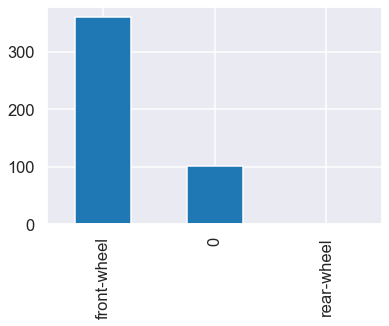

In [366]:
# transmission
# Yaris II występował wyłącznie z napędem na przód

print('transmission: ', df['transmission'].dtypes)
print('transmission: ', df['transmission'].unique())

df['transmission'].value_counts().plot(kind='bar');

door_count:  int64
door_count:  [5 3 0 4 2]


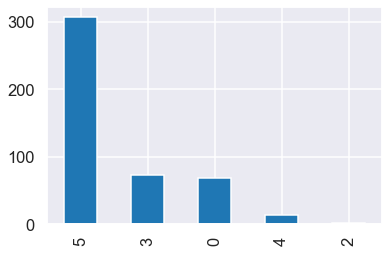

In [367]:
# door_count
print('door_count: ', df['door_count'].dtypes)
print('door_count: ', df['door_count'].unique())

df['door_count'].value_counts().plot(kind='bar');
# df[(df.door_count == 4)].sample(3)

def get_doors_cnt(doors):
    if doors >= 4: 
        return 5
    elif doors >= 2: 
        return 3
    else:
        return -1
    
if df['door_count'].nunique() > 3:
    df['door_count'] = df['door_count'].apply(lambda x : get_doors_cnt(x))

nr_seats:  int64
nr_seats:  [5 0 6 4 2]


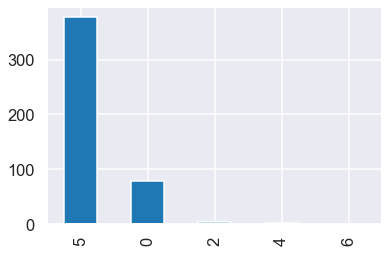

In [368]:
# nr_seats
print('nr_seats: ', df['nr_seats'].dtypes)
print('nr_seats: ', df['nr_seats'].unique())
df['nr_seats'].value_counts().plot(kind='bar');

In [369]:
# color
print('color: ', df['color'].dtypes)
print('color: ', *df['color'].unique())

color:  object
color:  grey white silver red blue other black yellow-gold green yellow brown-beige violet


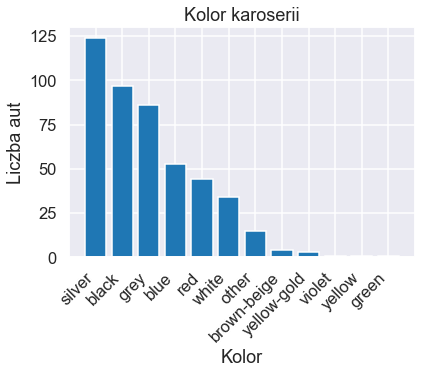

In [370]:
color_cnt = df['color'].value_counts()

fig = plt.figure()
axes = fig.add_axes([0.1 ,0.1 ,0.8, 0.8]) 
axes.bar(color_cnt.index, color_cnt.values)

axes.set_xlabel('Kolor')
axes.set_ylabel('Liczba aut')
axes.set_title('Kolor karoserii')

for label in axes.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

In [371]:
# price
print('price: ', df['price'].dtypes)
print('price: ', df['price'].nunique())

# price_raw
print('price_raw: ', df['price_raw'].dtypes)
print('price_raw: ', df['price_raw'].nunique())

price:  int64
price:  113
price_raw:  float64
price_raw:  141


In [372]:
# currency
print('currency: ', df['currency'].dtypes)
print('currency: ', df['currency'].unique())

currency:  object
currency:  ['0']


In [373]:
# country_origin
print('country_origin: ', df['country_origin'].dtypes)
print('country_origin: ', df['country_origin'].unique())

countries = {
    'f' : 'France',
    'pl' : 'Poland',
    'd' : 'Germany',
    'b' : 'Belgium',
    'nl' : 'Nederlands',
    'a': 'Austria',
    'i' : 'Italy',
    'gb' : 'Great Britan',
    'dk' : 'Denmark',
    's' : 'Sweden'
}

def is_from_poland(origin):
    if origin == 'pl':
        return 1
    else:
        return 0
    
df['origin_pl'] = df['country_origin'].apply(lambda x : is_from_poland(x))

country_origin:  object
country_origin:  ['f' 'pl' '0' 'd' 'b' 'nl' 'a' 'i' 'gb' 'dk' 's']


In [374]:
# registration
print('registration: ', df['registration'].dtypes)
print('registration: ', df['registration'].unique())

registration:  object
registration:  ['0' 'RST19536' 'ZGR VH37' 'RZE68062' 'FZ7305M' 'FZ7556M' 'ZDR 16488'
 'FZ7496M' 'WWL76138' 'K WV2222' 'LRY 84LR' 'KBC 72163' 'DJ91837'
 'TKI8551A' 'XGK506' 'RZE 74732' 'CG34523' 'RBR28917' 'ZMY 705AJ' 'XUM146'
 'FNW53TF' 'WY 98871' 'FMI 54886' 'WZY11627' 'TK 2396F' 'PK6174K'
 'N-JI164' 'lpu69059' 'WWY 71048']


---

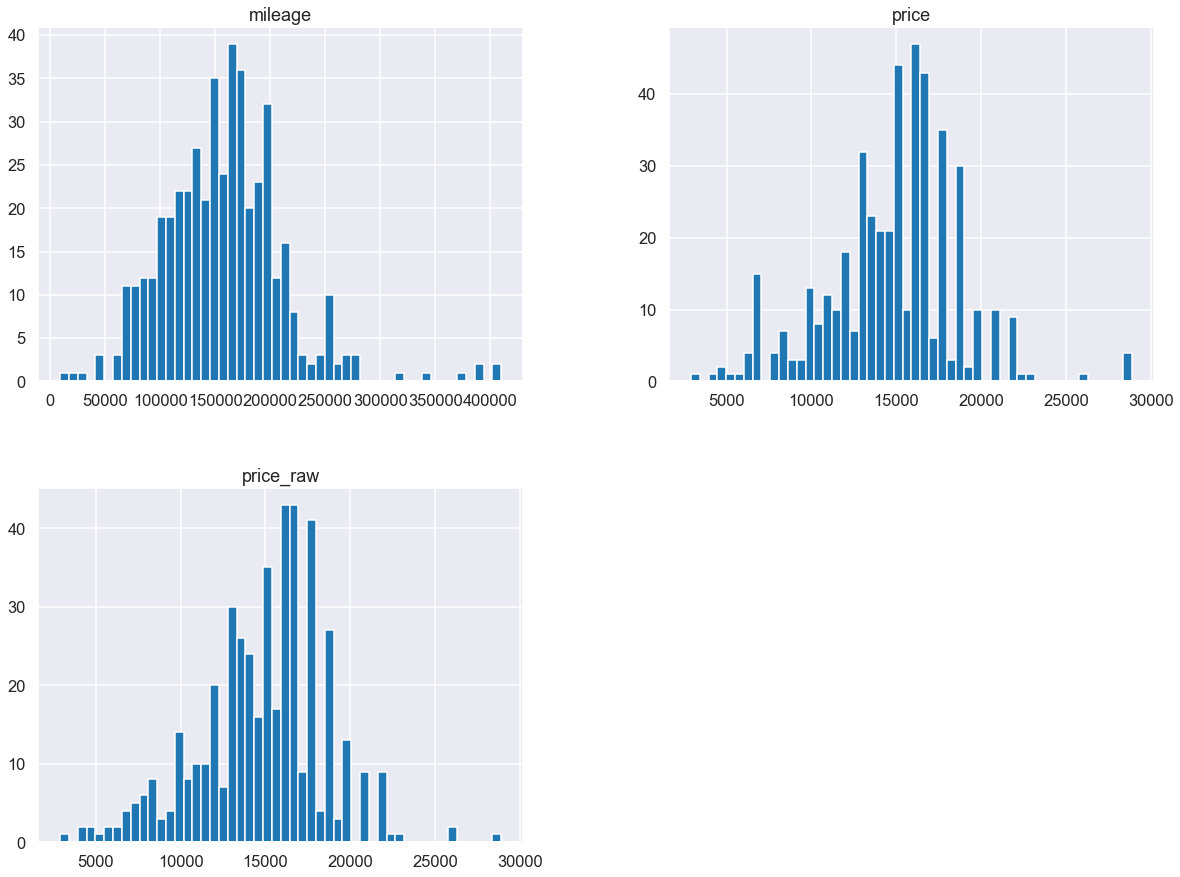

In [375]:
df[['mileage', 'price', 'price_raw']].hist(bins=50,figsize=(20,15))
plt.show()

In [376]:
def optimize_df():
    #df['offer_id'] = df['offer_id'].astype(np.uint32)
    df['offer_id'] = pd.to_numeric (df['offer_id'], downcast='unsigned')
    df['s_date'] = pd.to_datetime(df['s_date']) 
    df['e_date'] = pd.to_datetime(df['e_date']) 
    df['private_business'] = df['private_business'].apply(lambda x : str(x) == 'business')
    df['year'] = pd.to_numeric(df['year'], downcast='unsigned')
    df['mileage'] = pd.to_numeric(df['mileage'], downcast='unsigned')
    df['engine_capacity'] = pd.to_numeric(df['engine_capacity'], downcast='unsigned')
    df['engine_power'] = pd.to_numeric(df['engine_power'], downcast='unsigned')
    df['door_count'] = pd.to_numeric(df['door_count'], downcast='unsigned')
    df['nr_seats'] = pd.to_numeric(df['nr_seats'], downcast='unsigned')
    df['price'] = pd.to_numeric(df['price'], downcast='float')
    df['price_raw'] = pd.to_numeric(df['price_raw'], downcast='float')
    
%time optimize_df()    

Wall time: 17 ms


## Feature engineering

In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   offer_id          463 non-null    uint64        
 1   s_date            463 non-null    datetime64[ns]
 2   e_date            463 non-null    datetime64[ns]
 3   private_business  463 non-null    bool          
 4   region            463 non-null    object        
 5   city              463 non-null    object        
 6   model             463 non-null    object        
 7   year              463 non-null    uint16        
 8   mileage           463 non-null    uint32        
 9   engine_capacity   463 non-null    uint16        
 10  vin               463 non-null    object        
 11  fuel_type         463 non-null    object        
 12  engine_power      463 non-null    uint8         
 13  gearbox           463 non-null    object        
 14  transmission      463 non-

In [378]:
def price_history(offer_id,duplicated_id):
    if offer_id in duplicated_id:
        _df = df[['offer_id','price_raw','date']][df['offer_id'] == offer_id].sort_values(ascending=True, by='date')
        history_lst = _df['price_raw'].to_list()
        return history_lst
        
def general_features():
    # offer timespan:
    df['duration'] = (df['e_date'] - df['s_date']).dt.days.astype(np.uint16)
    
    # add information about price chnage
    duplicates = list(df[df.duplicated(['offer_id'], keep=False)]['offer_id'].unique())
    df['price_history'] = df['offer_id'].apply(lambda x : price_history(x, duplicates))
    df.drop_duplicates(subset='offer_id', keep="last", inplace=True)
    
%time general_features()

Wall time: 441 ms


In [379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 462
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   offer_id          342 non-null    uint64        
 1   s_date            342 non-null    datetime64[ns]
 2   e_date            342 non-null    datetime64[ns]
 3   private_business  342 non-null    bool          
 4   region            342 non-null    object        
 5   city              342 non-null    object        
 6   model             342 non-null    object        
 7   year              342 non-null    uint16        
 8   mileage           342 non-null    uint32        
 9   engine_capacity   342 non-null    uint16        
 10  vin               342 non-null    object        
 11  fuel_type         342 non-null    object        
 12  engine_power      342 non-null    uint8         
 13  gearbox           342 non-null    object        
 14  transmission      342 non-

In [380]:
# ogłoszenia z największą ilością zmiany ceny
# df.groupby(['offer_id'])['year'].count().sort_values(ascending=False)
# lista ogloszeń które zmianiły cenę
# _df = df[['offer_id','price_raw','date']][df['offer_id'] == 6036867722].sort_values(ascending=True, by='date')
# lst = _df['price_raw'].to_list()

df[df.duplicated(['offer_id'], keep=False)]['offer_id'].unique()
# list(set(df[df.duplicated(['offer_id'], keep=False)]['offer_id'].to_list()))

array([], dtype=uint64)

In [381]:
def price_history(offer_id,duplicated_id):
    if offer_id in duplicated_id:
        _df = df[['offer_id','price_raw','date']][df['offer_id'] == 6036867722].sort_values(ascending=True, by='date')
        history_lst = _df['price_raw'].to_list()
        return history_lst
        
duplicates = list(df[df.duplicated(['offer_id'], keep=False)]['offer_id'].unique())
  
df['price_history'] = df['offer_id'].apply(lambda x : price_history(x, duplicates))

In [382]:
df[['offer_id','price_raw', 'year','price_history']][df['offer_id'] == 6036867722]

,offer_id,price_raw,year,price_history
8,6036867722,16900.0,2009,None


In [383]:
#car features
def benefits_to_set(value):
    if str(value) == 'nan': return set(["nan"])
    return {attr.lower().strip() for attr in value}
    
def norm_name(name):
    return 'f_{0}'.format( name.lower().strip() )

def feature_columns(): 
    benefits_series = df['features'].str.split(' ').map(benefits_to_set)
    all_benefits = {benefit for row in benefits_series for benefit in row}
    
    feat_names = [norm_name(x) for x in all_benefits]
    
    for benefit in all_benefits:
        df[ norm_name(benefit) ] = benefits_series.map(lambda x: benefit in x).astype(np.int8)
    
    return feat_names

%time f = feature_columns()

Wall time: 76.5 ms


In [384]:
def old_plot(f):
    df[f].hist(bins=2,figsize=(20,20))
    plt.show()

# %time old_plot(f)

Wall time: 1.08 s


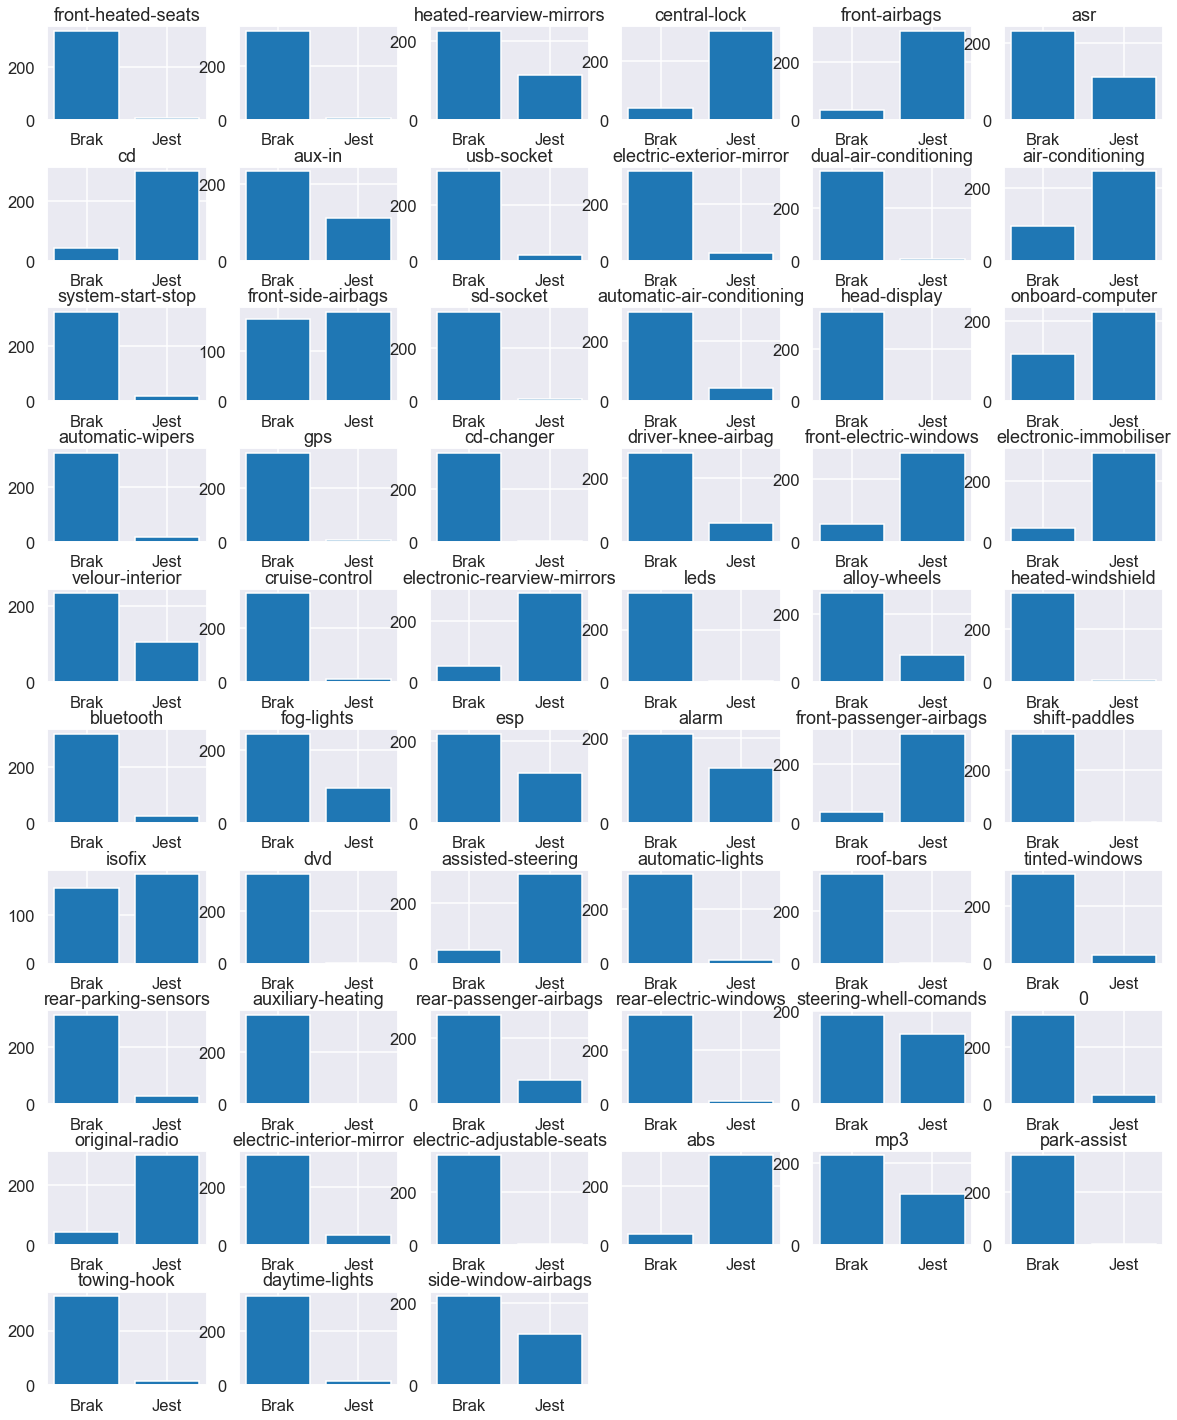

In [385]:
def new_plot(f):
    fig = plt.figure(figsize=(20, 25))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    fig.add_axes([0.1 ,0.1 ,0.8, 0.8])
    for i in range(len(f)):
        cnt = df[f[i]].value_counts()
        plt.subplot(10,6,i+1)
        plt.xticks(np.arange(2), ['Brak', 'Jest'])
        plt.bar(cnt.index, cnt.values, align='center')
        key = f[i][2:]
        plt.title(key)
        #plt.title(feat_en_pl.get(key))

%time new_plot(f)

### Aktywne ogłoszenia

In [386]:
# Aktywne 
df[df['e_date'] == '2020-06-07'].count()

offer_id                 7
s_date                   7
e_date                   7
private_business         7
region                   7
                        ..
f_mp3                    7
f_park-assist            7
f_towing-hook            7
f_daytime-lights         7
f_side-window-airbags    7
Length: 86, dtype: int64

In [387]:
def has_ac(x,y,z):
    if (x == 0) & (y == 0) & (z == 0): 
        return 0
    else:
        return 1
    
ac = ['f_air-conditioning', 'f_automatic-air-conditioning', 'f_dual-air-conditioning']

df['f_ac'] = df.apply(lambda x: has_ac(x['f_air-conditioning'], x['f_automatic-air-conditioning'], x['f_dual-air-conditioning']), axis=1)

# df['ac'].sample(5)

In [388]:
# return only not empty columns
def non_empty_feats():
    feats_lst = []
    for col in df.columns: 
        if col[0:2] == 'f_':
            if df[col].nunique() != 0:
                feats_lst.append(col)
    print(*feats_lst, sep='\n')
                
# non_empty_feats()                

## Wizualizacja

In [389]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure 
import bokeh_catplot
from bokeh.io import output_notebook, show


output_notebook(resources=None, verbose=False, hide_banner=True)

### Plotly express

In [390]:
import plotly
import plotly.express as px
import plotly.io as pio

def px_to_file():
    config = {"displayModeBar": False, "showTips": False}
    # Use directly Columns as argument. You can use tab completion for this!
    plt_sca_year = px.scatter(df, x=df.year, y=df.price_raw, template="presentation")
    plt_sca_year.show(config={'displayModeBar': False})

#     plotly.offline.plot(fig, "file.html")
    pio.write_html(plt_sca_year, file='./data/img/plt_sca_year.html', full_html=False, 
                   include_plotlyjs='cdn', auto_open=False,config=config)
    
%time px_to_file() 

Wall time: 757 ms


In [391]:

plt_price = px.histogram(df, x=df.price, template="presentation")
plt_price.show(config={'displayModeBar': False})

# pio.write_html(plt_price, file='./data/img/plt_price.html', full_html=False, include_plotlyjs='cdn', auto_open=False)

In [392]:
plt_mileage = px.histogram(df, x=df.mileage, template="presentation")
plt_mileage.show(config={'displayModeBar': False})

# pio.write_html(plt_mileage, file='./data/img/plt_mileage.html', full_html=False, include_plotlyjs='cdn', auto_open=False)

### Cena

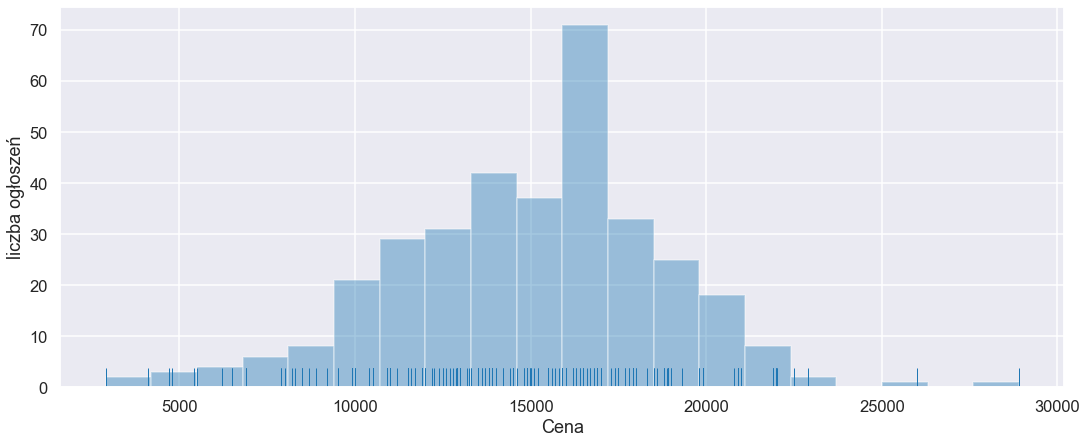

In [393]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,7))
chart = sns.distplot(df['price'], bins=20, kde=False, rug=True)
chart.set(xlabel='Cena', ylabel='liczba ogłoszeń');

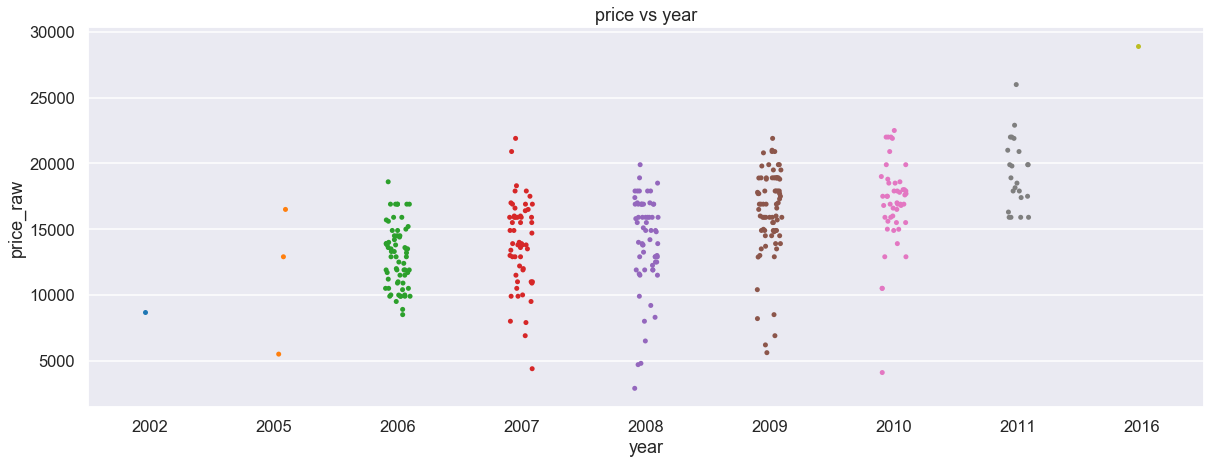

In [394]:
plt.figure(figsize=(20, 7))
plt.title('price vs year')  
plt.xlabel('year')  
plt.ylabel('price') 
sns.stripplot(x="year", y="price_raw", data=df);

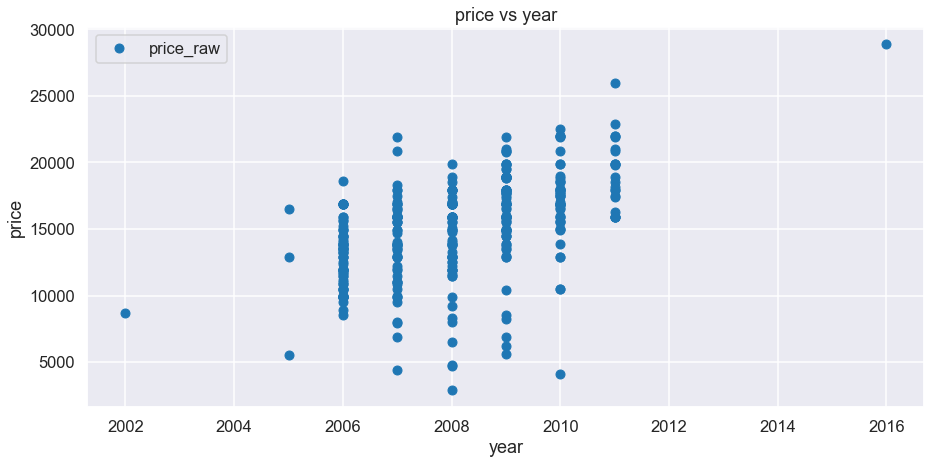

In [395]:
df.plot(x='year', y='price_raw', style='o', figsize=(15,7)) 
plt.title('price vs year')  
plt.xlabel('year')  
plt.ylabel('price')  
plt.show()

### przebieg

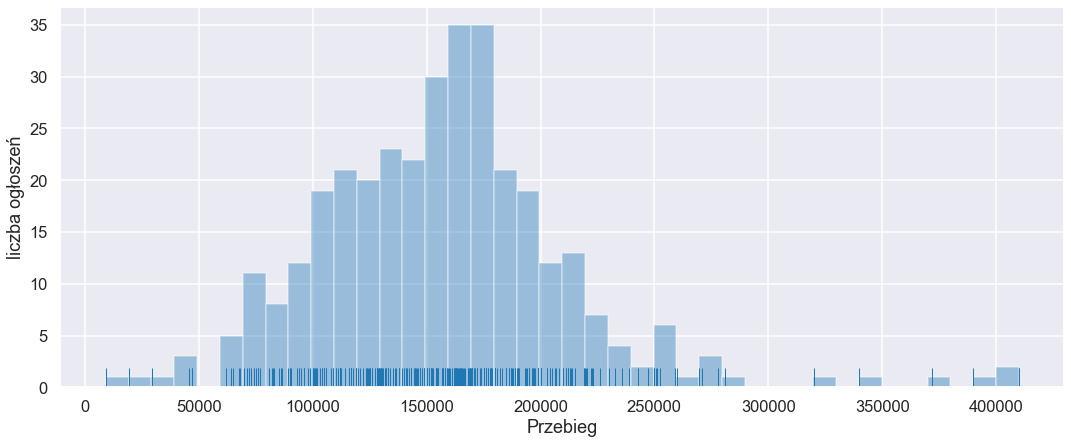

In [396]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,7))
chart = sns.distplot(df['mileage'], bins=40, kde=False, rug=True)
chart.set(xlabel='Przebieg', ylabel='liczba ogłoszeń');

### Czas trwania ogłoszenia

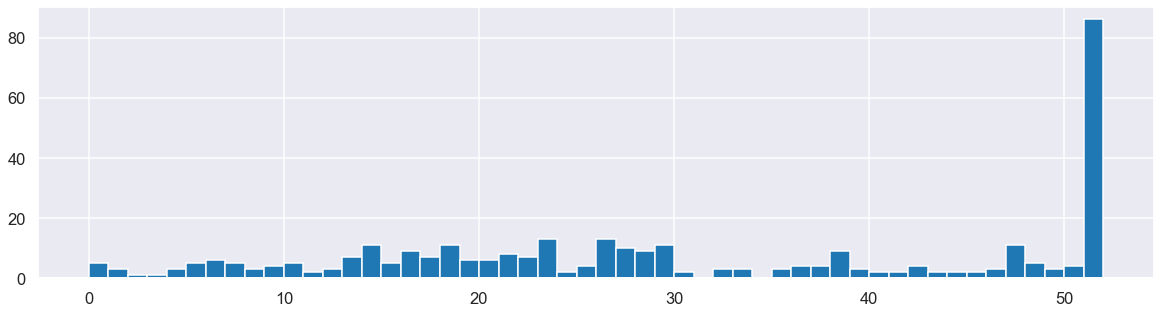

In [397]:
offer_duration = df['duration'].max()
df['duration'].hist(bins=offer_duration,figsize=(20,5))
plt.show()

In [398]:
# counts = df['duration'].value_counts()

# fig = plt.figure(figsize=(20,5))
# axes = fig.add_axes([0.1 ,0.1 ,0.8, 0.8]) 
# axes.bar(counts.index, counts.values)

# axes.set_xlabel('Województwo')
# axes.set_ylabel('Liczba aut')
# axes.set_title('Liczba ogłoszeń wg województw')

# locs, labels = fig.xticks() 

# # for label in axes.get_xticklabels():
# #     xticks(np.arange(30))
# # #   label.set_rotation(45)
# # #   label.set_ha('right')

### Cena końcowa - 99 percentyl

In [399]:
filter_max = np.percentile(df['price'],99)
filter_max

22294.999999999985

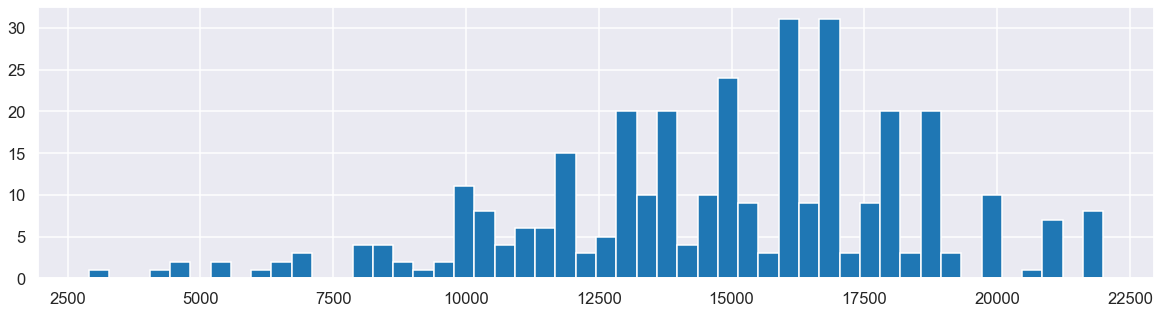

In [400]:
df_filter = df[df['price'] < filter_max]
df_filter['price'].hist(bins=50,figsize=(20,5))
plt.show()

### Przebieg

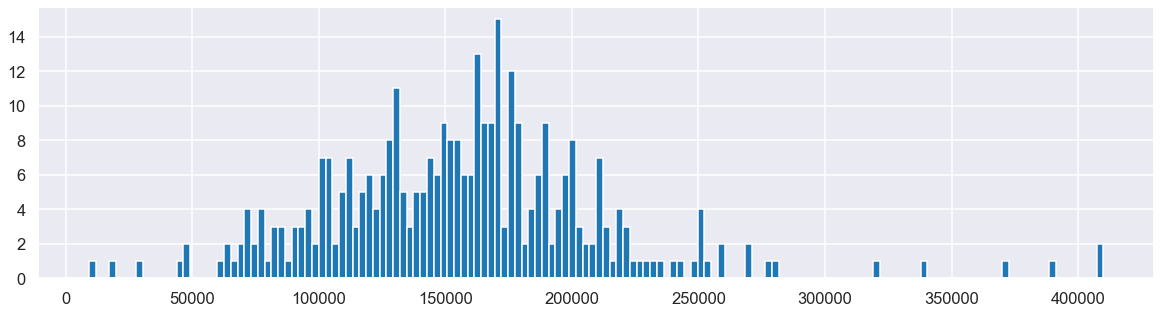

In [401]:
df['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg - 99 percentyl

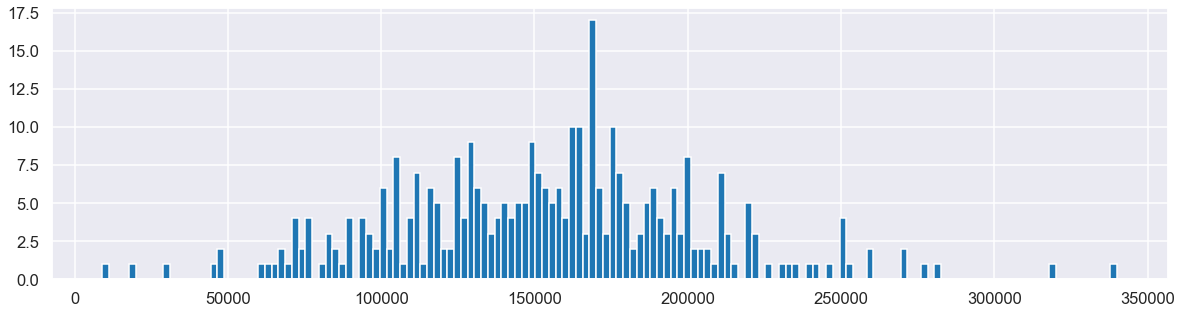

In [402]:
df_mileage = df[df['mileage'] < np.percentile(df['mileage'],99)]
df_mileage['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

In [403]:
df[df['year'] == 2009 ].shape[0]

77

Wall time: 204 ms


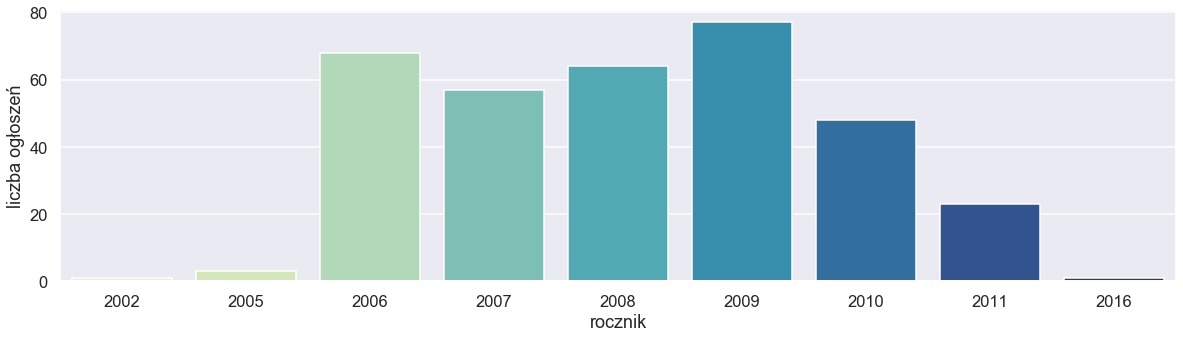

In [404]:
def plot_year():
    year_list = df['year'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['year'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='rocznik', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns.png')
    
%time plot_year()


Wall time: 776 ms


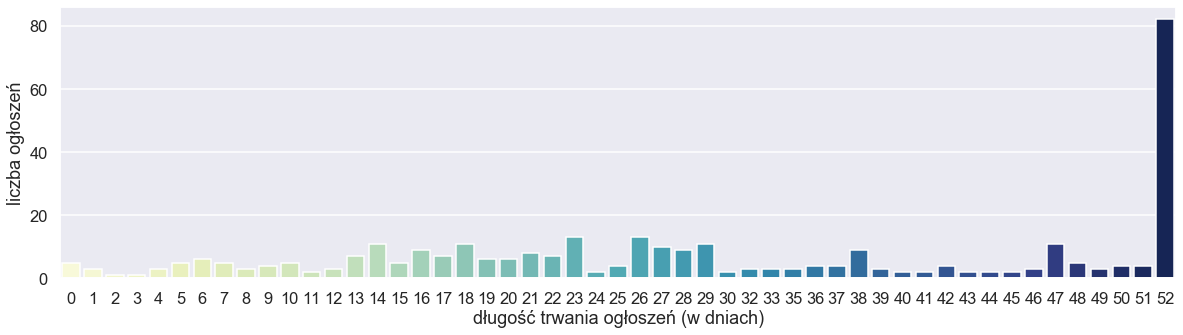

In [405]:
# OTOMOTO
# CZas ogłoszenia 15 / 30 dni

def plot_duration():
    year_list = df['duration'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['duration'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='długość trwania ogłoszeń (w dniach)', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns_duration.png')
    
%time plot_duration()

---

In [406]:
df.columns

Index(['offer_id', 's_date', 'e_date', 'private_business', 'region', 'city',
       'model', 'year', 'mileage', 'engine_capacity', 'vin', 'fuel_type',
       'engine_power', 'gearbox', 'transmission', 'door_count', 'nr_seats',
       'color', 'features', 'price', 'price_raw', 'date', 'currency',
       'country_origin', 'registration', 'engine', 'origin_pl', 'duration',
       'price_history', 'f_front-heated-seats', 'f_',
       'f_heated-rearview-mirrors', 'f_central-lock', 'f_front-airbags',
       'f_asr', 'f_cd', 'f_aux-in', 'f_usb-socket',
       'f_electric-exterior-mirror', 'f_dual-air-conditioning',
       'f_air-conditioning', 'f_system-start-stop', 'f_front-side-airbags',
       'f_sd-socket', 'f_automatic-air-conditioning', 'f_head-display',
       'f_onboard-computer', 'f_automatic-wipers', 'f_gps', 'f_cd-changer',
       'f_driver-knee-airbag', 'f_front-electric-windows',
       'f_electronic-immobiliser', 'f_velour-interior', 'f_cruise-control',
       'f_electronic-rear

---

Na podstawie powyższej analizy wytypowałem cechy do dalszych prac

In [407]:
df[important_feats][(df['year'] >= 2005) & (df['year'] <= 2011)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340 entries, 0 to 462
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   offer_id                  340 non-null    uint64        
 1   s_date                    340 non-null    datetime64[ns]
 2   e_date                    340 non-null    datetime64[ns]
 3   private_business          340 non-null    bool          
 4   region                    340 non-null    object        
 5   year                      340 non-null    uint16        
 6   mileage                   340 non-null    uint32        
 7   fuel_type                 340 non-null    object        
 8   door_count                340 non-null    int64         
 9   color                     340 non-null    object        
 10  price                     340 non-null    float32       
 11  origin_pl                 340 non-null    int64         
 12  f_0                   

In [408]:
important_feats = ['offer_id', 's_date', 'e_date', 'private_business','region','year', 
                   'mileage', 'fuel_type', 'door_count', 'color','price','origin_pl',
                   'f_0','f_central-lock','f_alloy-wheels','f_ac', 'f_rear-parking-sensors',
                  'f_mp3','f_front-electric-windows', 'f_fog-lights', 'f_steering-whell-comands','price', 'price_raw']



#df_clean = df.filter(important_feats, axis=1).copy()

#  copy data to new dataframe (year range 2005 - 2011)
df_clean = df[important_feats][(df['year'] >= 2005) & (df['year'] <= 2011)].copy()

pd.options.display.max_columns=25
df_clean.sample(3)

,offer_id,s_date,e_date,private_business,region,year,mileage,fuel_type,door_count,color,price,origin_pl,f_0,f_central-lock,f_alloy-wheels,f_ac,f_rear-parking-sensors,f_mp3,f_front-electric-windows,f_fog-lights,f_steering-whell-comands,price,price_raw
379,6073135396,2020-04-17,2020-05-02,False,malopolskie,2007,135200,diesel,5,silver,14900.0,0,0,1,1,1,0,1,1,0,0,14900.0,14900.0
320,6071910409,2020-04-17,2020-05-14,False,kujawsko-pomorskie,2006,160350,petrol,-1,grey,12500.0,0,0,1,0,1,0,0,1,0,1,12500.0,12500.0
44,6059503917,2020-04-17,2020-05-16,False,mazowieckie,2007,259000,petrol,5,other,10999.0,1,0,1,1,1,0,0,0,0,0,10999.0,10999.0


In [409]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340 entries, 0 to 462
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   offer_id                  340 non-null    uint64        
 1   s_date                    340 non-null    datetime64[ns]
 2   e_date                    340 non-null    datetime64[ns]
 3   private_business          340 non-null    bool          
 4   region                    340 non-null    object        
 5   year                      340 non-null    uint16        
 6   mileage                   340 non-null    uint32        
 7   fuel_type                 340 non-null    object        
 8   door_count                340 non-null    int64         
 9   color                     340 non-null    object        
 10  price                     340 non-null    float32       
 11  origin_pl                 340 non-null    int64         
 12  f_0                   

## TODO: ML

In [410]:
import random as rn
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import scikitplot as skplt

import joblib

seed = 0
np.random.seed(seed)
rn.seed(seed)

xgb_params = {
    'max_depth' : 5, 
    'n_estimators' : 100, 
    'learning_rate' : 0.3, 
    'random_state' : 0
}

model = xgb.XGBRegressor(**xgb_params, objective ='reg:squarederror')

In [411]:
xgb.__version__

'1.0.2'

['private_business', 'year', 'mileage', 'door_count', 'origin_pl', 'f_0', 'f_central-lock', 'f_alloy-wheels', 'f_ac', 'f_rear-parking-sensors', 'f_mp3', 'f_front-electric-windows', 'f_fog-lights', 'f_steering-whell-comands', 'region_cat', 'fuel_type_cat', 'color_cat']
Wall time: 193 ms


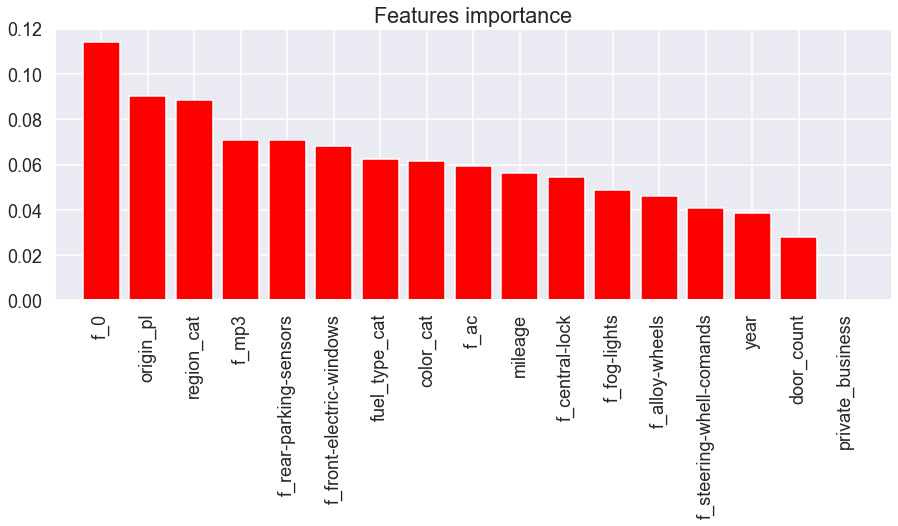

In [443]:
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['price', 'price_raw', 'offer_id']
    return [x for x in feats if x not in black_list]

# not used yet - categories have to be common with user predicteed car details
def get_cat_feats(df):
    cat_feats = df.select_dtypes(include=[np.object]).columns
    black_list = ['features', 'model']
    cat_feats_list =  [x for x in cat_feats if x not in black_list]

    for cat_feat in cat_feats_list:
        df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

    
feats = get_feats(df_clean)
print(feats)

X = df_clean[feats].values
y = df_clean['price'].values


def simple_split_model(model, X,y):
    #train and predict
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
#     plt.hist(y_test - y_pred);
    
    skplt.estimators.plot_feature_importances(model, feature_names=feats, title='Features importance', x_tick_rotation=90, figsize=(15, 5));

%time simple_split_model(model, X, y)

In [413]:
df_clean[feats].head(1)

,private_business,year,mileage,door_count,origin_pl,f_0,f_central-lock,f_alloy-wheels,f_ac,f_rear-parking-sensors,f_mp3,f_front-electric-windows,f_fog-lights,f_steering-whell-comands
0,False,2009,111000,5,0,1,0,0,0,0,0,0,0,0


In [429]:
# save model
joblib.dump(model, './data/models/yaris_200530.pkl') 

['./data/models/yaris_200530.pkl']

In [415]:
# https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
model.save_model('./data/models/yaris.json')


In [437]:
#['private_business', 'year', 'mileage', 'door_count', 'f_air-conditioning', 'f_alloy-wheels', 'f_steering-whell-comands', 'f_front-electric-windows']
car_info = pd.DataFrame(columns = feats)

car_details = {
    'private_business' : "{0:d}".format(0),
    'year' : "{0:d}".format(2008),
    'mileage' : "{0:d}".format(142000), 
    'door_count' : "{0:d}".format(5), 
    'origin_pl' : "{0:d}".format(1),
    'f_0' : "{0:d}".format(0),
    'f_ac' : "{0:d}".format(1), 
    'f_alloy-wheels': "{0:d}".format(0),
    'f_rear-parking-sensors' : "{0:d}".format(1),
    'f_steering-whell-comands' : 0, 
    'f_fog-lights' : 0,
    'f_mp3' : 0,
    'f_front-electric-windows' : 0,
    'f_central-lock' : 0
}

car_info = car_info.append(car_details , ignore_index=True)
car_info

,private_business,year,mileage,door_count,origin_pl,f_0,f_central-lock,f_alloy-wheels,f_ac,f_rear-parking-sensors,f_mp3,f_front-electric-windows,f_fog-lights,f_steering-whell-comands,region_cat,fuel_type_cat,color_cat
0,0,2008,142000,5,1,0,0,0,1,1,0,0,0,0,NaN,NaN,NaN


In [438]:
y_pred = model.predict(car_info.values)
print('Cena powinna wynosić: ', y_pred[0], 'zł')

Cena powinna wynosić:  16600.742 zł


In [418]:
#load model & predict
loaded_model = joblib.load('./data/models/yaris_200530.pkl')
result = loaded_model.predict(car_info.values)
print('Cena powinna wynosić: ',result[0], 'zł')

Cena powinna wynosić:  15905.738 zł


In [419]:
print(X[0].shape)

(14,)


In [420]:
get_cat_feats(df_clean)
feats = get_feats(df_clean)
print(feats)

['private_business', 'year', 'mileage', 'door_count', 'origin_pl', 'f_0', 'f_central-lock', 'f_alloy-wheels', 'f_ac', 'f_rear-parking-sensors', 'f_mp3', 'f_front-electric-windows', 'f_fog-lights', 'f_steering-whell-comands', 'region_cat', 'fuel_type_cat', 'color_cat']
